In [28]:
!pip install -qU "langchain-nvidia-ai-endpoints"

In [29]:
from google.colab import userdata
import os

os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")
os.environ["LANGSMITH_API_KEY"] = userdata.get("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = userdata.get("LANGSMITH_TRACING")
os.environ["LANGSMITH_PROJECT"] = userdata.get("LANGSMITH_PROJECT")
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")
os.environ["NVIDIA_API_KEY"] = userdata.get("NVIDIA_API_KEY")

In [30]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("nvidia/llama-3.1-nemotron-ultra-253b-v1", model_provider="nvidia")

/usr/local/lib/python3.11/dist-packages/langchain_nvidia_ai_endpoints/_common.py:217: UserWarning: Found nvidia/llama-3.1-nemotron-ultra-253b-v1 in available_models, but type is unknown and inference may fail.
  warnings.warn(


In [31]:
!pip install -qU langchain-nvidia-ai-endpoints

In [32]:
from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings

embeddings = NVIDIAEmbeddings(model="NV-Embed-QA")

In [33]:
!pip install -qU langchain-core

In [34]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [35]:
!pip install --upgrade --quiet langgraph langchain-community beautifulsoup4

In [36]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

In [37]:
_ = vector_store.add_documents(documents=all_splits)

In [38]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [39]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [40]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [41]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

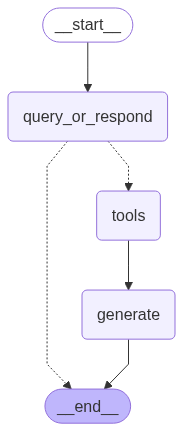

In [42]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [43]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello


/usr/local/lib/python3.11/dist-packages/langchain_nvidia_ai_endpoints/chat_models.py:592: UserWarning: Model 'nvidia/llama-3.1-nemotron-ultra-253b-v1' is not known to support tools. Your tool binding may fail at inference time.
  warnings.warn(


================================== Ai Message ==================================

<TOOLCALL>[]</TOOLCALL>


In [44]:
input_message = "What is Task Decomposition? Do not answer yourself. Use the tool"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition? Do not answer yourself. Use the tool


/usr/local/lib/python3.11/dist-packages/langchain_nvidia_ai_endpoints/chat_models.py:592: UserWarning: Model 'nvidia/llama-3.1-nemotron-ultra-253b-v1' is not known to support tools. Your tool binding may fail at inference time.
  warnings.warn(


================================== Ai Message ==================================
Tool Calls:
  retrieve (cF5mHYzB7)
 Call ID: cF5mHYzB7
  Args:
    query: Task Decomposition definition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to g

In [45]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

In [46]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is Task Decomposition?


/usr/local/lib/python3.11/dist-packages/langchain_nvidia_ai_endpoints/chat_models.py:592: UserWarning: Model 'nvidia/llama-3.1-nemotron-ultra-253b-v1' is not known to support tools. Your tool binding may fail at inference time.
  warnings.warn(


================================== Ai Message ==================================
Tool Calls:
  retrieve (83gYc6KRw)
 Call ID: 83gYc6KRw
  Args:
    query: Task Decomposition definition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to g

In [47]:
input_message = "Can you look up some common ways of doing it?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up some common ways of doing it?


/usr/local/lib/python3.11/dist-packages/langchain_nvidia_ai_endpoints/chat_models.py:592: UserWarning: Model 'nvidia/llama-3.1-nemotron-ultra-253b-v1' is not known to support tools. Your tool binding may fail at inference time.
  warnings.warn(


================================== Ai Message ==================================
Tool Calls:
  retrieve (e4nYuqwcT)
 Call ID: e4nYuqwcT
  Args:
    query: common ways of task decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner 

In [49]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)

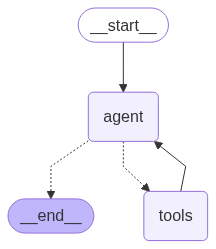

In [50]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [51]:
config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
================================== Ai Message ==================================
Tool Calls:
  retrieve (HBPeO94dD)
 Call ID: HBPeO94dD
  Args:
    query: standard method for Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planni